## Warmstarting Hyperparameter Search
In another notebook [Hyperparameter Warmstarting](hyper-parameter-optimization-warm-starting.ipynb) we investigated the effect of warmstarting on one pipeline and task (Task 31 and Pipeline 7707).
In this notebook, we generalize the code to arbitrary tasks and pipelines.
The process is as follows:
- The input is one task and a list of flow ids. 
- We retrieve the flow and task and all the runs and evaluations of the flows on the task
- For every flow, we extract the variable hyperparameters and estimate the search space (for now this would be static function)
- We warm start the trial object of hyperopt.
- For every flow, compare the warm starting vs no warm starting

Lastly, we should extract the reusable code (hyperparameter extraction and warmstarting) to a separate file.

In [48]:
from openml import datasets, tasks, runs, flows, setups, config, evaluations
from workloadoptimization.essentials import Component, ExperimentObject, ExperimentGraph, ExperimentParser
from workloadoptimization.hyperopt_helper import TrialConverter
from workloadoptimization.openml_helper import OpenMLReader
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import uuid
import networkx as nx
import sklearn
from networkx.drawing.nx_agraph import graphviz_layout
from openmlstudy14.preprocessing import ConditionalImputer
from matplotlib2tikz import save as tikz_save
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

In [65]:
flow_ids = [8568,8353, 8315, 7707]
task_ids = [31]

In [66]:
def extractExperiments(filePath, taskIds, flowIds):
    openMLReader = OpenMLReader()
    if os.path.isfile(filePath):
        return pd.read_pickle(filePath)
    frames = []
    for t in taskIds:
        for f in flowIds:
            frames.append(openMLReader.getTopRuns(-1,f,t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(filePath)
    return Experiments

# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extractExperiments('meta/hyper-opt-experiment-31-all', task_ids, flow_ids)

In [67]:
OPENML_FLOWS = {}
FLOW_IDS = Experiments.flow_id.unique()
for f in FLOW_IDS:
    try:
        #print f
        fl = flows.get_flow(f)
        OPENML_FLOWS[f] = fl 
    except:
        print 'error for {}'.format(f)
parser = ExperimentParser()
experimentObjects = parser.extractOpenMLFlows(Experiments, OPENML_FLOWS)

In [68]:
def updateSearchSpace(searchSpace, experimentObject):
    for k,v in experimentObject.extractParams().iteritems():
        if searchSpace.has_key(k):
            searchSpace[k].append(v)
        else:
            searchSpace[k] = [v]
    return searchSpace
    
    
# Find the range of all the hyperparameters for setting up the search space
POSSIBLE_SEARCH_SPACES = {}
for e in experimentObjects:
    if POSSIBLE_SEARCH_SPACES.has_key(e.flow):
        searchSpace = POSSIBLE_SEARCH_SPACES[e.flow]
        POSSIBLE_SEARCH_SPACES[e.flow] = updateSearchSpace(searchSpace, e)
    else:
        searchSpace = {}
        POSSIBLE_SEARCH_SPACES[e.flow] = updateSearchSpace(searchSpace, e)

In [69]:
# Find the hyperparameters with constant values so we can set them once and do not include them in the search space
SEARCH_SPACES = {}
CONSTANT_PARAMS_SPACE = {}
for pipeline in POSSIBLE_SEARCH_SPACES.keys():
    DYNAMIC_PARAMS = {}
    # For now we are not interested in constant params, so we ignore them
    CONSTANT_PARAMS = {}
    for k in POSSIBLE_SEARCH_SPACES[pipeline].keys():
        try:
            size = len(set(POSSIBLE_SEARCH_SPACES[pipeline][k]))
            if size == 1:
                CONSTANT_PARAMS[k] = POSSIBLE_SEARCH_SPACES[pipeline][k][0]
            else:
                # is it safe to assume parameters are unique
                DYNAMIC_PARAMS[k] = list(set(POSSIBLE_SEARCH_SPACES[pipeline][k]))
        except: 
            CONSTANT_PARAMS[k] = POSSIBLE_SEARCH_SPACES[pipeline][k][0] 
            
    SEARCH_SPACES[pipeline] = DYNAMIC_PARAMS
    CONSTANT_PARAMS_SPACE[pipeline] = CONSTANT_PARAMS
    # we are not interested in the constant parameters, but we keep them for logging
    #SEARCH_SPACES[pipeline]['constant'] = CONSTANT_PARAMS

In [96]:
# construct the search space
from hyperopt import hp
from hyperopt.pyll import scope, as_apply
# This is the magic function that will return the search space based on the given points
# For now, we will hardcore for each pipeline
# This will be part of the research and I have a todo on my list of the paper

def space8568(points):
    space = {}
    space['conditionalimputer__strategy'] = hp.choice('conditionalimputer__strategy', [u'mean', u'median', u'most_frequent'])
    array = np.array(points['randomforestclassifier__max_features'])
    array = np.delete(array, np.where(array == 'auto'), axis=0)
    array = array.astype(np.float)
    space['randomforestclassifier__max_features'] = hp.uniform('randomforestclassifier__max_features', min(array), max(array))
    space['randomforestclassifier__min_samples_leaf'] = hp.choice('randomforestclassifier__min_samples_leaf',range(1,21))
    space['onehotencoder__sparse'] = hp.choice('onehotencoder__sparse',[True, False])
    space['randomforestclassifier__min_impurity_split'] = hp.choice('randomforestclassifier__min_impurity_split',[None, 1e-07])
    space['randomforestclassifier__min_samples_split'] = hp.choice('randomforestclassifier__min_samples_split', range(2,21))
    #array = np.array(points['randomforestclassifier__max_depth'])
    #array = np.delete(array, np.where(array == None), axis=0)
    #array = array.astype(np.float)
    #space['randomforestclassifier__max_depth'] = hp.uniform('randomforestclassifier__max_depth', min(array), max(array))
    space['randomforestclassifier__criterion'] = hp.choice('randomforestclassifier__criterion',[u'gini', u'entropy'])
    space['randomforestclassifier__bootstrap'] = hp.choice('randomforestclassifier__bootstrap',[True, False])
    return space 
def space8353(points):
    space = {}
    space['clf__gamma'] = hp.lognormal('clf__gamma', 0.04, 1.0)
    space['clf__tol'] = hp.lognormal('clf__tol',-7, 1)
    space['clf__shrinking'] = hp.choice('clf__shrinking',[True, False])
    space['clf__C'] = hp.lognormal('clf__C',7, 1.1)
    space['clf__coef0'] = hp.uniform('clf__coef0', -1, 1)
    return space

def space8315(points):
    space = {}
    space['clf__bootstrap'] = hp.choice('clf__bootstrap',[True, False])
    space['clf__criterion'] = hp.choice('clf__criterion',[u'gini', u'entropy'])
    space['clf__max_features'] = hp.uniform('clf__max_features',0 , 1)
    space['clf__min_samples_split'] = hp.choice('clf__min_samples_split', range(2,21))
    space['clf__min_samples_leaf'] = hp.choice('clf__min_samples_leaf', range(1,21))
    return space
    
def space7707(points):
    space = {}
    # between 1.0509652110524482e-05 0.09706102908291375
    space['classifier__tol'] = hp.lognormal('classifier__tol',-7, 1)
    # between 3.122280314190532e-05 7.998532268538166
    space['classifier__gamma'] = hp.lognormal('classifier__gamma',0.0001, 1.3)
    # One of True or False
    space['classifier__C'] = hp.lognormal('classifier__C',2.5, 3)
    # choice
    space['imputation__strategy'] = hp.choice('imputation__strategy', [u'mean', u'median', u'most_frequent'])
    # choice
    space['classifier__degree'] = hp.choice('classifier__degree', [1, 2, 3, 4, 5])
    # Between -0.9942534412466477 0.9975887639931769
    space['classifier__coef0'] = hp.uniform('classifier__coef0', -1, 1)
    # True or False
    space['classifier__shrinking'] = hp.choice('classifier__shrinking',[True, False])
    return space
    
def finalizeConstantSpace():
    CONSTANT_PARAMS_SPACE[8568]['randomforestclassifier__max_depth'] = None
def extractSearchSpace(pointSpace):
    SPACE = {}
    for k,v in pointSpace.iteritems():
        if k == 8568:
            space = space8568(pointSpace[8568])
            SPACE[8568] = space
        if k == 8353:
            space = space8353(pointSpace[8353])
            SPACE[8353] = space
        if k == 8315:
            space = space8315(pointSpace[8315])
            SPACE[8315] = space
        if k == 7707:
            space = space7707(pointSpace[7707])
            SPACE[7707] = space
    return SPACE

hyperOptSpace = extractSearchSpace(SEARCH_SPACES)

In [97]:
flow = flows.get_flow(flow_id=8568)
# Hack for the non existing arbok.preprocessing.ConditionalImputer Class
flow.components['conditionalimputer'].class_name = 'hyperimp.utils.preprocessing.ConditionalImputer2'
pipeline8568 = flows.flow_to_sklearn(flow)

flow = flows.get_flow(flow_id=8353)
pipeline8353 = flows.flow_to_sklearn(flow)

flow = flows.get_flow(flow_id=8315)
pipeline8315 = flows.flow_to_sklearn(flow)

flow = flows.get_flow(flow_id=7707)
# Hack for changing the sklearn version dependecy as it does not affect the pipelines
flow.dependencies = u'sklearn==0.19.1\nnumpy>=1.6.1\nscipy>=0.9'
for v in flow.components.itervalues():
    v.dependencies = u'sklearn==0.19.1\nnumpy>=1.6.1\nscipy>=0.9'
pipeline7707 = flows.flow_to_sklearn(flow)

In [98]:
# set the constant parameters and define the objective function
finalizeConstantSpace()
pipeline8568.set_params(**CONSTANT_PARAMS_SPACE[8568])
pipeline8353.set_params(**CONSTANT_PARAMS_SPACE[8353])
pipeline8315.set_params(**CONSTANT_PARAMS_SPACE[8315])
pipeline7707.set_params(**CONSTANT_PARAMS_SPACE[7707])

def objective8568(params):
    print '.',
    pipeline8568.set_params(**params)
    try:
        pipeline8568.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
    accuracy = pipeline8568.score(X_test, y_test)
    return 1 - accuracy

def objective8353(params):
    print '.',
    pipeline8353.set_params(**params)
    try:
        pipeline8353.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
    accuracy = pipeline8353.score(X_test, y_test)
    return 1 - accuracy

def objective8315(params):
    print '.',
    pipeline8315.set_params(**params)
    try:
        pipeline8315.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
    accuracy = pipeline8315.score(X_test, y_test)
    return 1 - accuracy

def objective7707(params):
    print '.',
    # seems when tol is big (greater than 1) scikit learn throws an exception
    # I couldn't find a way to cap a value in the search space of hyperopt, 
    # this is the alternative solution
    if params['classifier__tol'] > 0.2:
        params['classifier__tol'] = 0.2
    pipeline7707.set_params(**params)
    try:
        pipeline7707.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
    accuracy = pipeline7707.score(X_test, y_test)
    #print 'accuracy = {}'.format(accuracy)
    return 1 - accuracy

In [99]:
# load the dataset
task = tasks.get_task(task_id=31)
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices,test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
target=dataset.default_target_attribute,
return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [100]:
# sort based on the loss
def getObjectsForPipeline(flowID):
    exs = []
    for e in experimentObjects:
        if e.flow == flowID:
            exs.append(e)
    return sorted(exs, key=lambda eo: 1 - eo.quality, reverse=True)

sortedObjects8568 = getObjectsForPipeline(8568)
sortedObjects8353 = getObjectsForPipeline(8353)
sortedObjects8315 = getObjectsForPipeline(8315)
sortedObjects7707 = getObjectsForPipeline(7707)

In [101]:
from hyperopt import fmin, tpe, Trials, rand
def hyperParamExperiment(trialsDatabase, numberOfExperiments, numberOfEvals, searchSpace, objectiveFunction):
    losses = np.empty([0, numberOfEvals])
    initialSize = len(trialsDatabase.trials)
    
    for i in range(numberOfExperiments):
        print ''
        print 'Experiment {}'.format(i + 1),
        trials = Trials()
        trials.insert_trial_docs(trialsDatabase.trials)
        trials.refresh() 
        
        fmin(objectiveFunction,
                searchSpace,
                algo=tpe.suggest,
                max_evals=initialSize + numberOfEvals,
                trials=trials)
        
        newTrials = Trials()
        newTrials.insert_trial_docs(trials.trials[initialSize:])
        newTrials.refresh() 
        losses = np.insert(losses, i ,np.array(newTrials.losses()) , 0)  
    return losses

In [103]:
trialConverter = TrialConverter()

warmTrials8568 = trialConverter.trialsFromExperimentObjects(hyperOptSpace[8568], sortedObjects8568)

warmTrials8353 = trialConverter.trialsFromExperimentObjects(hyperOptSpace[8353], sortedObjects8353)

warmTrials8315 = trialConverter.trialsFromExperimentObjects(hyperOptSpace[8315], sortedObjects8315)

warmTrials7707 = trialConverter.trialsFromExperimentObjects(hyperOptSpace[7707], sortedObjects7707)


Error in parsing: Exception('This should be solved: auto should be float for run 9203558 since the hyperopt space requires a float',)
Error in parsing: Exception('This should be solved: auto should be float for run 9203559 since the hyperopt space requires a float',)
Error in parsing: Exception('This should be solved: auto should be float for run 9203325 since the hyperopt space requires a float',)
Error in parsing: Exception('This should be solved: auto should be float for run 9203326 since the hyperopt space requires a float',)
Error in parsing: Exception('This should be solved: auto should be float for run 9203328 since the hyperopt space requires a float',)
Error in parsing: Exception('This should be solved: auto should be float for run 9203329 since the hyperopt space requires a float',)
Error in parsing: Exception('This should be solved: auto should be float for run 9203331 since the hyperopt space requires a float',)
Error in parsing: Exception('This should be solved: auto shoul

Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully 

Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully 

Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully 

Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully 

In [113]:
import warnings
warnings.filterwarnings('ignore')


warmLosses8568 = hyperParamExperiment(warmTrials8568, 10,100, hyperOptSpace[8568], objective8568)
warmLosses8353 = hyperParamExperiment(warmTrials8353, 10,100, hyperOptSpace[8353], objective8353)
warmLosses8315 = hyperParamExperiment(warmTrials8315, 10,100, hyperOptSpace[8315], objective8315)
warmLosses7707 = hyperParamExperiment(warmTrials7707, 10,100, hyperOptSpace[7707], objective7707)


Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 4 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 5 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Experiment 7 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 8 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 9 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 10 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [114]:
warnings.filterwarnings('ignore')
coldTrials = Trials()    
coldLosses8568 = hyperParamExperiment(coldTrials, 10,100, hyperOptSpace[8568], objective8568)
coldTrials = Trials()   
coldLosses8353 = hyperParamExperiment(coldTrials, 10,100, hyperOptSpace[8353], objective8353)
coldTrials = Trials()   
coldLosses8315 = hyperParamExperiment(coldTrials, 10,100, hyperOptSpace[8315], objective8315)
coldTrials = Trials()   
coldLosses7707 = hyperParamExperiment(coldTrials, 10,100, hyperOptSpace[7707], objective7707)


Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 4 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 5 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Experiment 2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 4 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 5 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 6 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [115]:
def meltLosses(warmLosses, coldLosses):
    warmAvg = np.average(warmLosses,axis=0)
    coldAvg = np.average(coldLosses,axis=0)
    ExperimentAverages = pd.DataFrame({'No':coldAvg,'Yes':warmAvg}).reset_index()
    ExperimentAverages.columns= ['Trial','No','Yes']
    ExperimentAverages.head()
    melted = ExperimentAverages.melt('Trial', var_name='Warmstarting', value_name='Loss')
    return melted

In [116]:
df8568 = meltLosses(warmLosses8568, coldLosses8568)
df8353 = meltLosses(warmLosses8353, coldLosses8353)
df8315 = meltLosses(warmLosses8315, coldLosses8315)
df7707 = meltLosses(warmLosses7707, coldLosses7707)

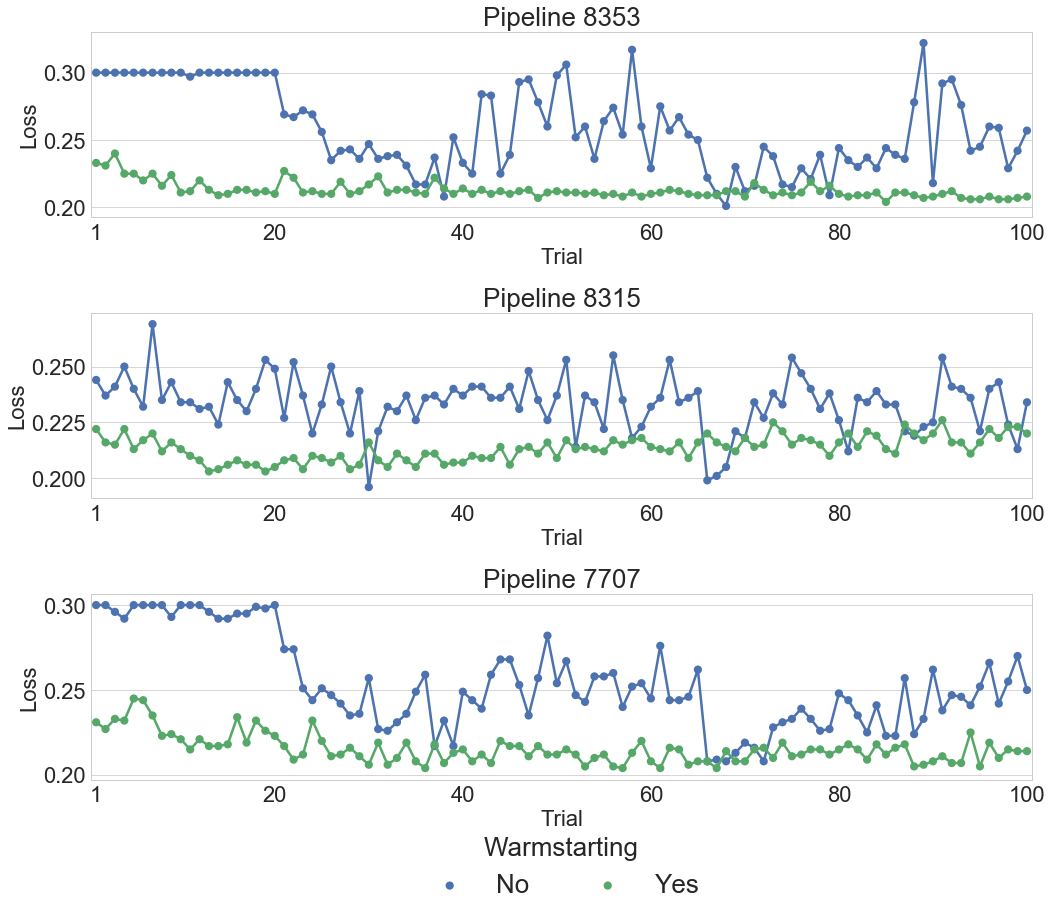

In [137]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
#ax4 = fig.add_subplot(314)
axes = [ax1,ax2,ax3]
dfs = [df8353, df8315, df7707]
labelsize = 22
titlesize = 26
pipelines = ['8353','8315','7707']
for i in range(len(pipelines)):
    g = sns.factorplot(data=dfs[i], 
                       x = 'Trial', 
                       y = 'Loss', 
                       hue = 'Warmstarting', 
                       size=8, aspect=2,ax = axes[i], legend=False, legend_out = False)
    axes[i].set_ylabel('Loss', fontsize=labelsize)
    axes[i].set_xlabel('Trial', fontsize=labelsize)
    axes[i].set(xticks=[0,19,39,59,79,99])
    axes[i].set_title('Pipeline {}'.format(pipelines[i]), fontsize = titlesize)
    axes[i].set_xticklabels(['1','20','40','60','80','100'], fontsize = labelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=labelsize)
    #axes[i].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.,)
    axes[i].legend_.remove()
    plt.close(g.fig)
    
legend = axes[-1].legend(title = 'Warmstarting',
           bbox_to_anchor=(0.5, -.25),
           loc='upper center',
           borderaxespad=0.,
           fancybox = True,
           shadow=True,
           ncol = 2, 
           fontsize = titlesize)
plt.setp(legend.get_title(),fontsize = titlesize)
plt.tight_layout()
plt.savefig('figures/paper/task31-3flows-cold-starting-warm-avgtrials.eps', format='eps', dpi=1000, bbox_inches='tight')

In [ ]:
pipelines = ['8353','8315','7707']
warms = np.repeat(len(set(np.where(warmLosses8353 == np.min(warmLosses8353))[0])),4)
colds = np.repeat(len(set(np.where(coldLosses == 0.18999999999999995)[0])),4)
counts = pd.DataFrame({'Pipeline':pipelines,'Yes':warms,'No':colds}).melt('Pipeline', var_name='Warmstarting', value_name='Count')

In [130]:
np.min(warmLosses8353)
np.min(coldLosses8353)

0.17000000000000004

In [133]:
np.min(warmLosses8315)
np.min(coldLosses8315)

0.17000000000000004

In [136]:
np.min(warmLosses7707)
np.min(coldLosses7707)

0.18000000000000005